# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
import seaborn as sns

# **Mount Drive**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

data = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

print("Data shape:", data.shape)
print("Data head:", data.head())

Mounted at /content/drive
Data shape: (284807, 31)
Data head:    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.1

# **Data Preprocessing**

In [ ]:
X = data.drop(columns=['Class', 'Time'])
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Defining the neural **network**

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output_layer(x))
        return x

model = NeuralNetwork(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# **Training the model**

In [ ]:
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/15, Loss: 0.0116
Epoch 2/15, Loss: 0.0030
Epoch 3/15, Loss: 0.0027
Epoch 4/15, Loss: 0.0025
Epoch 5/15, Loss: 0.0023
Epoch 6/15, Loss: 0.0022
Epoch 7/15, Loss: 0.0020
Epoch 8/15, Loss: 0.0019
Epoch 9/15, Loss: 0.0019
Epoch 10/15, Loss: 0.0018
Epoch 11/15, Loss: 0.0017
Epoch 12/15, Loss: 0.0017
Epoch 13/15, Loss: 0.0015
Epoch 14/15, Loss: 0.0015
Epoch 15/15, Loss: 0.0015


# **Model Evalutation**

Train Accuracy: 0.9996, Test Accuracy: 0.9994


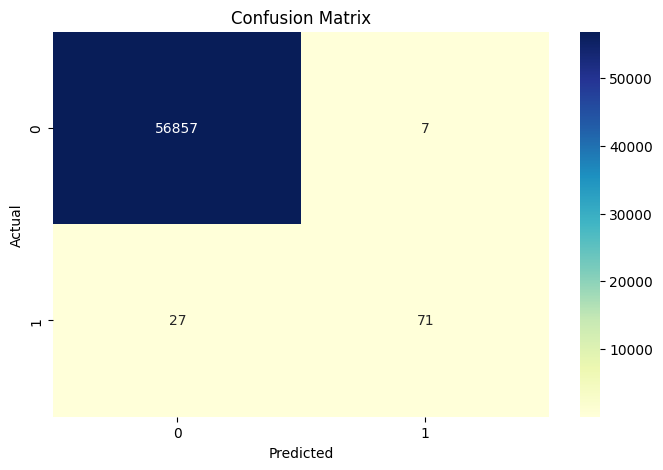

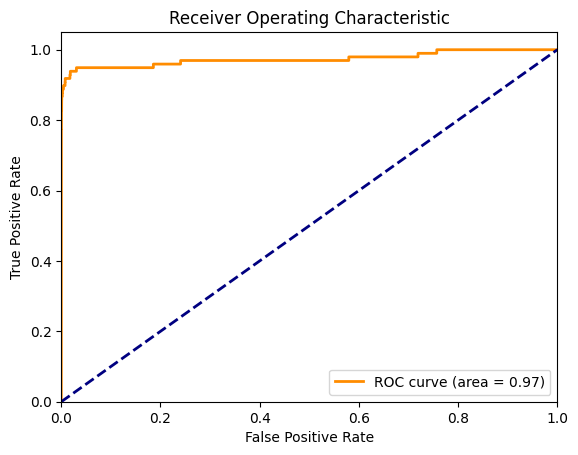

AUC: 0.9736650569062739


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor)
    y_pred_test = model(X_test_tensor)

y_pred_train_bin = (y_pred_train >= 0.5).float()
y_pred_test_bin = (y_pred_test >= 0.5).float()

train_accuracy = (y_pred_train_bin.eq(y_train_tensor).sum() / y_train_tensor.shape[0]).item()
test_accuracy = (y_pred_test_bin.eq(y_test_tensor).sum() / y_test_tensor.shape[0]).item()
print(f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

cm = confusion_matrix(y_test_tensor, y_pred_test_bin)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

fpr, tpr, _ = roc_curve(y_test_tensor, y_pred_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("AUC:", roc_auc_score(y_test_tensor, y_pred_test))